In [1]:
import time
import sys
! pip install numpy
import numpy as np
! pip install matplotlib
import matplotlib.pyplot as plt
import math
import os
from matplotlib.pyplot import imread
! pip install patchify
from patchify import patchify

np.random.seed(1)


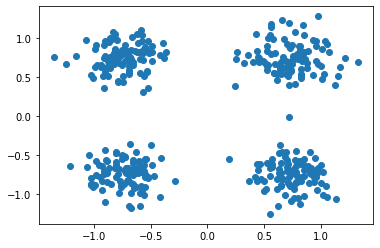

In [2]:
X = np.load("./data_clustering.npy")
plt.scatter(X[:,0], X[:,1])
plt.show()

In [3]:
def initialise_parameters(m, X):
    C = X[np.random.choice(X.shape[0], m)]
    return C

C = initialise_parameters(4, X)
print(C)

[[ 0.55638768  1.19083041]
 [ 0.99468733 -0.63105385]
 [-0.80861347 -0.47487527]
 [ 0.83443335  0.7038998 ]]


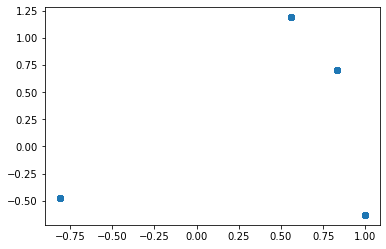

In [4]:
def E_step(C, X):
    # YOUR CODE HERE
    i = 0
    while i < len(C):
        if i==0:
            dm = np.array(np.sqrt(((X-C[i,:])**2).sum(axis=1)),ndmin=2).T
        else:
            dm = np.concatenate((dm,np.array(np.sqrt(((X-C[i,:])**2).sum(axis=1)),ndmin=2).T),axis=1)
        i+=1
    index = np.argmin(dm, axis=1)
    out = np.array(C[index])
    return out
    
    
    
    
L = E_step(C, X)
plt.scatter(L[:, 0], L[:, 1])
plt.show()

In [5]:
def M_step(C, X, L):
    # YOUR CODE HERE
    i=0
    m, n = X.shape
    newC = np.array(C,copy = True)
    while i<len(C):
        cluster = X[np.where(np.all(L == C[i], axis = 1))].reshape(-1,n)
        newC[i]= np.mean(cluster, axis=0)
        i+=1
    return newC

print('Before:')
print(C)
print('\nAfter:')
new_C = M_step(C, X, L)
print(new_C)

Before:
[[ 0.55638768  1.19083041]
 [ 0.99468733 -0.63105385]
 [-0.80861347 -0.47487527]
 [ 0.83443335  0.7038998 ]]

After:
[[-0.18550673  0.94593855]
 [ 0.74859936 -0.74619961]
 [-0.76830416 -0.16807746]
 [ 0.75645564  0.69249107]]


Initial Parameters:
[[ 0.55638768  1.19083041]
 [ 0.99468733 -0.63105385]
 [-0.80861347 -0.47487527]
 [ 0.83443335  0.7038998 ]]

Final Parameters:
[[ 0.72539561  0.75302836]
 [-0.73312486 -0.73655558]
 [ 0.74859936 -0.74619961]
 [-0.74965351  0.7531092 ]]


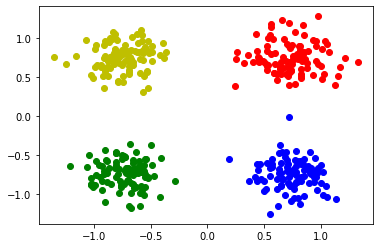

In [6]:
def kmeans(X, m, threshold):
    # YOUR CODE HERE
    C = initialise_parameters(m, X)
    L = E_step(C, X)
    loss = np.sqrt(((X-L)**2).sum())
    while True:
        C = M_step(C, X, L)
        L = E_step(C, X)
        nloss = np.sqrt(((X-L)**2).sum())
        dif = abs(loss - nloss)
        loss = nloss
        if dif<threshold:
            C = M_step(C, X, L)
            break
    return (C,L)

#CODE TO DISPLAY YOUR RESULTS. DO NOT MODIFY.
C_final, L_final = kmeans(X, 4, 1e-7)
print('Initial Parameters:')
print(C)
print('\nFinal Parameters:')
print(C_final)

def allocator(X, L, c):
    cluster = []
    for i in range(L.shape[0]):
        if np.array_equal(L[i, :], c):
            cluster.append(X[i, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b', 'y']
for i in range(4):
    cluster = allocator(X, L_final, C_final[i, :])
    plt.scatter(cluster[:,0], cluster[:,1], c=colours[i])
plt.show()

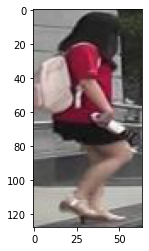

In [7]:
train_images = []
for file in os.listdir("./train"):
    if file.endswith(".jpg"):
        im = imread("./train/" + file)
        train_images.append(im)
        assert im.shape == (128, 64,3)
plt.imshow(train_images[0])
plt.show()

Before splitting, the image size is (128, 64, 3)
After splitting, the patches are (128, 8, 8, 3)
A patch is like:


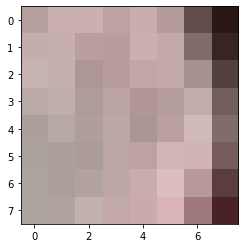

In [8]:
def patchify_images(image):
    return patchify(image, (8, 8, 3), step=8).reshape((-1, 8, 8, 3))

patches = patchify_images(train_images[0])
print(f'Before splitting, the image size is {train_images[0].shape}')
print(f'After splitting, the patches are {patches.shape}')
print('A patch is like:')
plt.imshow(patches[50])
plt.show()

In [9]:
def compute_patch_feature(patch,feature_dim):
    #YOUR CODE HERE
    m ,n ,k = patch.shape
#     return np.array(np.mean(patch,axis=(0,1)),ndmin=2)
    
    
    bin_size = int(feature_dim/3)
#     RGB histgram
    red = np.matrix.flatten(patch[:,:,0])
    green = np.matrix.flatten(patch[:,:,1])
    blue = np.matrix.flatten(patch[:,:,2])
#     bin_size = 3
    H_red, edge_red = np.histogram(red, bins=bin_size, range = (0,256))
    H_green, edge_green = np.histogram(green, bins=bin_size, range = (0,256))
    H_blue, edge_blue = np.histogram(blue, bins=bin_size, range = (0,256))
    return np.array(np.concatenate((H_red,H_green,H_blue),axis = 0),ndmin=2)
    
    
    
#     Mean RGB Value
#     feature = np.zeros((m,k))
#     for i in range(m):
#         feature[i,:] = np.mean(patch[i],axis=0)
#         print(feature[i,:].shape)
#     return np.array(np.matrix.flatten(feature),ndmin=2)



start = time.time()
print(f'The shape of the feature of a patch is :{compute_patch_feature(patches[50],12).shape} in my implementation.')
end = time.time()
print(f'It takes {end-start} seconds to compute the feature for one image patch.')

The shape of the feature of a patch is :(1, 12) in my implementation.
It takes 0.0 seconds to compute the feature for one image patch.


In [44]:
def create_vocabulary(train_images,npoints,feature_dim):
    #YOUR CODE HERE
    nimage = len(train_images)
    m, n, r = train_images[0].shape
#     feature_dim = 9
    pop = np.zeros((1,feature_dim))
    for i in range(nimage):
        patches = patchify_images(train_images[i])
        for j in range(m):
            if i == 0 and j ==0:
                pop[0] = compute_patch_feature(patches[j],feature_dim)
            else:
                pop = np.concatenate((pop,compute_patch_feature(patches[j],feature_dim)),axis=0)
#     npoints = 30
    vocab = kmeans(pop, npoints, 1e-7)[0]
    print(len(np.unique(vocab, axis=0,return_counts=True)[1]))
    return vocab#,len(np.unique(vocab, axis=0,return_counts=True)[1])

feature_dim = 12
start = time.time()
# alist = [20,21,22,23,24]
# for j in range(len(alist)):
#     count = 0
#     for i in range(30):
vocabulary = create_vocabulary(train_images,40,feature_dim)
#         count = count + add
#     print("average is ",count/30)
end = time.time()
print(f'The shape of my vocabulary is {vocabulary.shape}.')
print(f'It takes {end-start} seconds to generate the vocabulary.' )

39
The shape of my vocabulary is (40, 12).
It takes 13.476609468460083 seconds to generate the vocabulary.


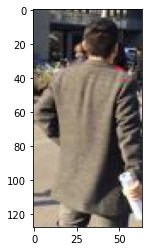

In [40]:
gallery_images = []
gallery_filenames = []
for file in os.listdir("./gallery"):
    if file.endswith(".jpg"):
        im = imread("./gallery/" + file)
        gallery_images.append(im)
        gallery_filenames.append(file)
query_image = imread("./val_query/0003_c5_0013.jpg")
# show a query image
plt.imshow(query_image)
plt.show()

It takes 2.7348618507385254 seconds to get the matching results of a query
Your query image is:


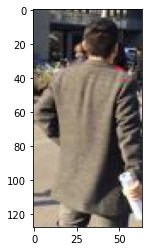

The best matching is:
1


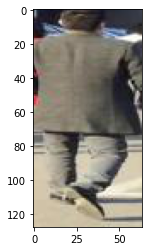

2


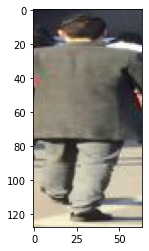

3


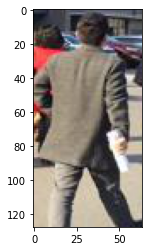

4


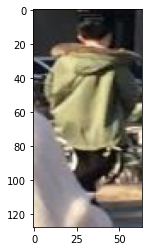

5


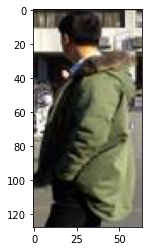

6


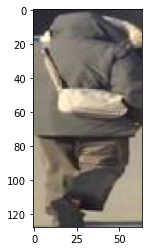

7


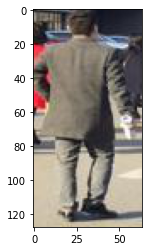

8


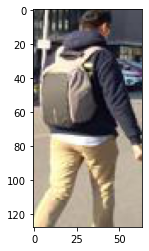

9


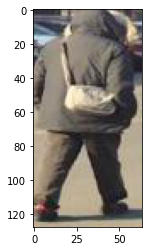

10


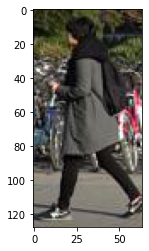

11


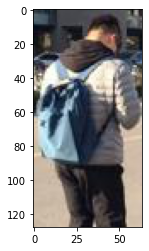

12


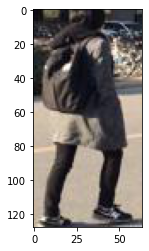

13


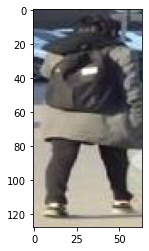

14


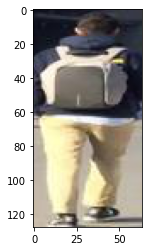

15


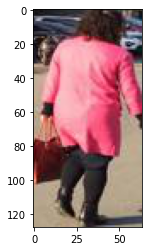

16


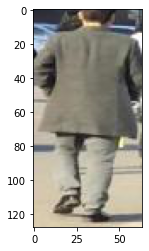

17


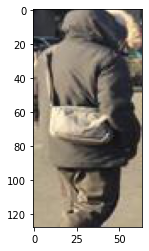

18


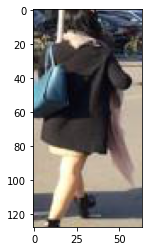

19


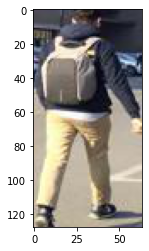

20


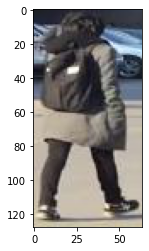

21


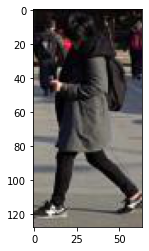

22


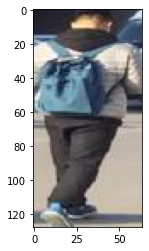

23


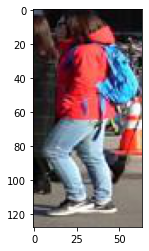

24


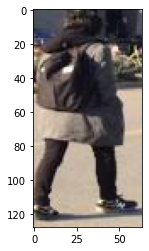

25


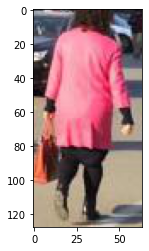

26


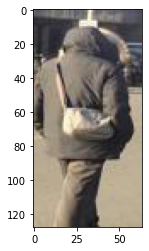

27


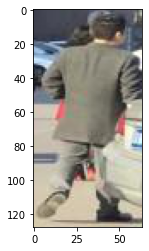

28


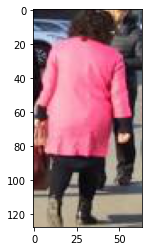

29


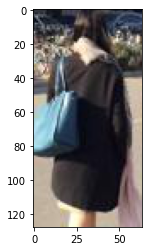

30


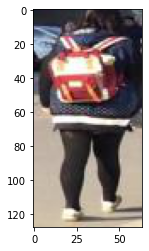

31


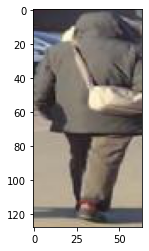

32


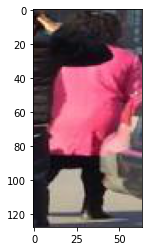

33


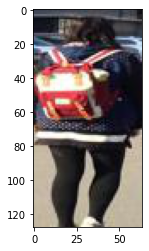

34


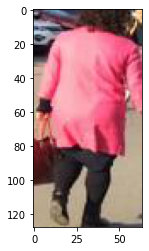

35


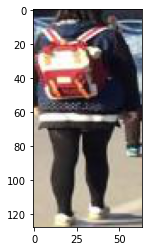

36


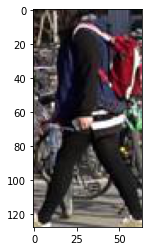

37


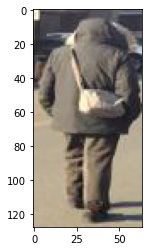

38


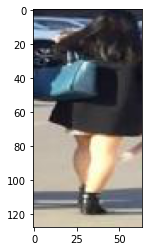

39


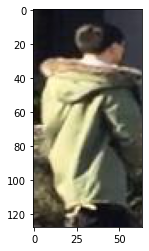

40


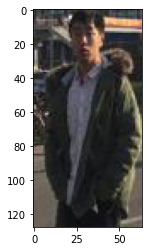

41


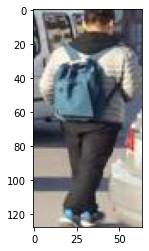

42


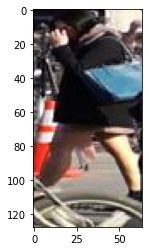

43


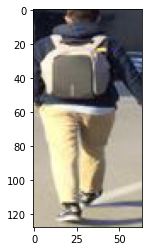

44


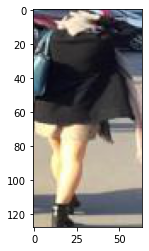

45


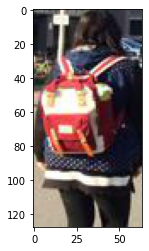

46


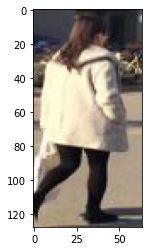

47


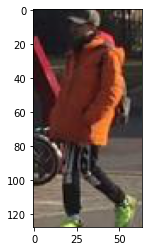

48


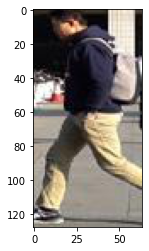

49


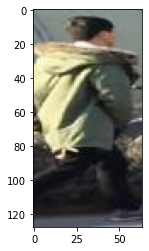

50


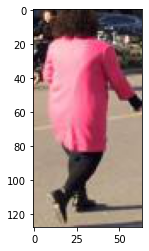

51


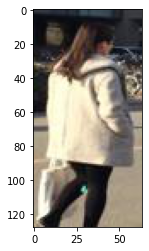

52


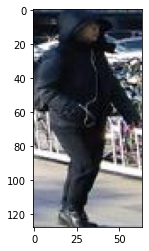

53


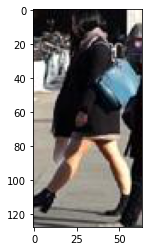

54


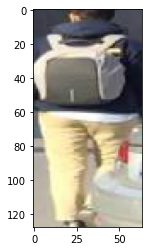

55


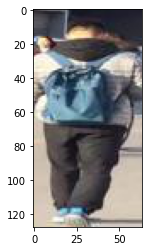

56


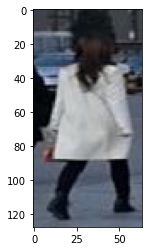

57


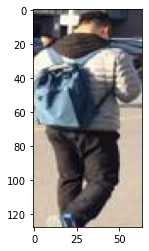

58


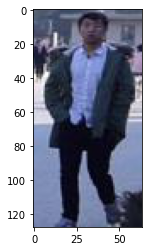

59


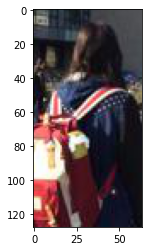

60


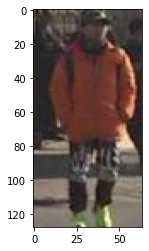

61


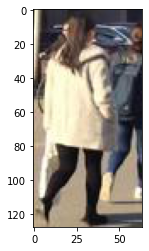

62


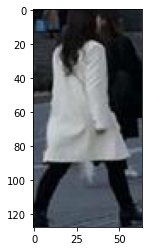

63


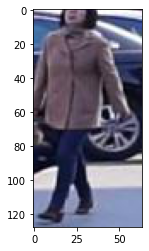

64


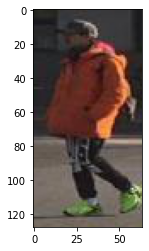

65


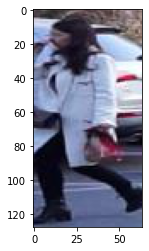

66


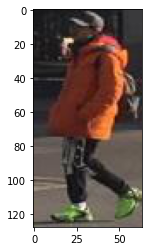

67


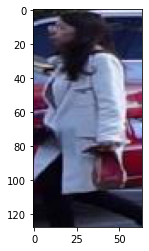

68


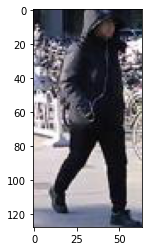

69


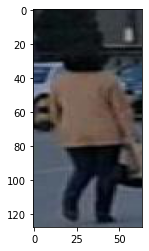

70


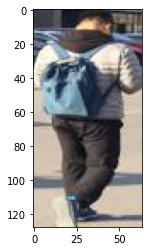

71


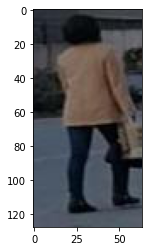

72


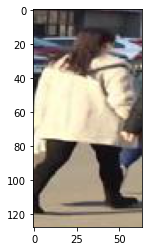

73


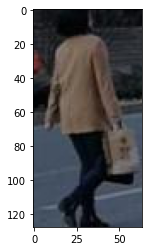

74


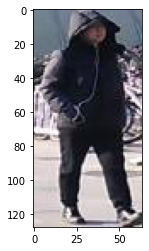

75


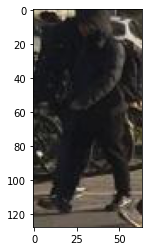

76


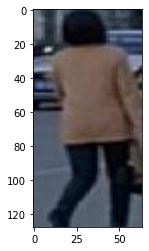

77


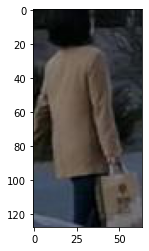

78


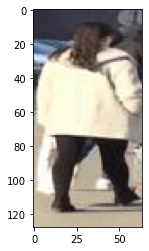

79


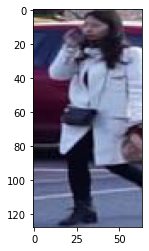

80


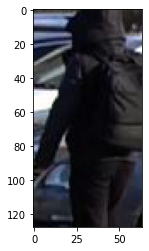

81


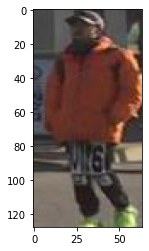

82


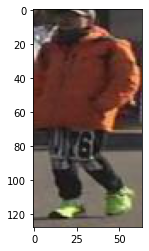

83


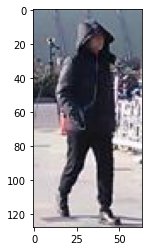

84


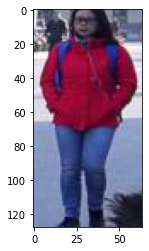

85


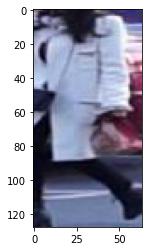

86


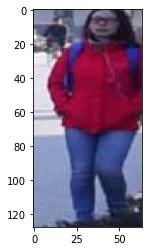

87


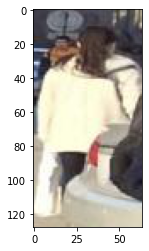

88


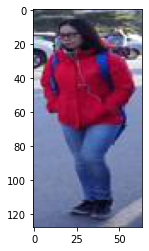

89


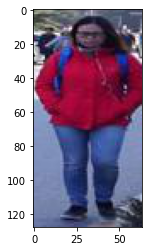

90


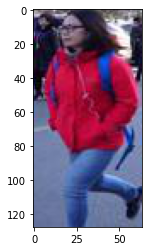

In [45]:
def get_hist(image,bin_size,vocabulary,feature_dim):
        feature_dim = bin_size*3
        patches = patchify_images(image)
        m, n, r, j = patches.shape
        pop = np.zeros((m,feature_dim), dtype = np.float64)
        for j in range(m):
            pop[j] = compute_patch_feature(patches[j],feature_dim)
        assign = E_step(vocabulary, pop)         # use E step to assign each point to vocabulary
        hist = np.zeros((1,len(vocabulary)))
        for i in range(len(vocabulary)):
#             print(assign[np.where(np.all(assign==vocabulary[i], axis = 1))])
#             print(len(assign[np.where(np.all(assign==vocabulary[i], axis = 1))]))
            hist[:,i] = len(assign[np.where(np.all(assign==vocabulary[i], axis = 1))])
#         print((hist[0]).sum())
        return hist

def reweight_tf_idf(histograms):
    re_hists  = np.zeros(histograms.shape)
    N = histograms.shape[0]
    n_i = np.sum(histograms > 0, axis=0)
    for hist_id in range(histograms.shape[0]):
        n_d  = np.sum(histograms[hist_id])
        for bin_id in range(len(histograms[hist_id])): 
            re_hists[hist_id, bin_id] = histograms[hist_id, bin_id]/ n_d * np.log(N/n_i[bin_id])
#             print(re_hists[hist_id, bin_id], histograms[hist_id, bin_id], n_d, N, n_i[bin_id])
    return re_hists

def compute_cost_matrices(histograms):
    N = histograms.shape[0]
    cost_matrix_eucl  = np.zeros((N,N))
    cost_matrix_cos  = np.zeros((N,N))

    for row, hist_row in enumerate(histograms):
        for col, hist_col in enumerate(histograms):
            eucl_dist = np.linalg.norm(hist_row-hist_col)
            cost_matrix_eucl[row, col] = eucl_dist
            cos_sim = np.dot(hist_row, hist_col) / (np.linalg.norm(hist_row)* np.linalg.norm(hist_col))
            cost_matrix_cos[row, col] = cos_sim
    return cost_matrix_eucl, cost_matrix_cos

# def image_similarity_ranking(gallery_images, query_image, vocabulary, gallery_filenames,feature_dim):
#     #YOUR CODE HERE
#     bin_size = 4
    
#     # get feature from query_image
# #     print(query_image.shape)
#     query_hist = get_hist(query_image,bin_size,vocabulary,feature_dim)

#     # get feature from gallery_images
#     n_gallery = len(gallery_images)
#     gal_hist = np.zeros((n_gallery,len(query_hist[0])), dtype = np.float64)
#     cos_dis = np.zeros((n_gallery), dtype = np.float64)
#     for i in range(n_gallery):
#         gal_hist[i,:] = get_hist(gallery_images[i],bin_size,vocabulary,feature_dim)
    
#     con_hist = np.concatenate((query_hist,gal_hist),axis=0)
#     target_matrix = compute_cost_matrices(reweight_tf_idf(con_hist))

# #     query_hist = re_hist[0]
# #     for i in range(n_gallery):
# #         image_hist = re_hist[i+1]
# #         cos_dis[i] = np.dot(query_hist, image_hist.T) / (np.linalg.norm(query_hist)* np.linalg.norm(image_hist))
#     rank_index = np.argsort(target_matrix[0])[::-1].astype(int)
#     file = []
#     for i in range(0,n_gallery):
#         file.append(gallery_filenames[rank_index[i]])
#     return file
def image_similarity_ranking(gallery_images, query_image, vocabulary, gallery_filenames,feature_dim):
    #YOUR CODE HERE
    bin_size = 4
    
    # get feature from query_image
#     print(query_image.shape)
    query_hist = get_hist(query_image,bin_size,vocabulary,feature_dim)

    # get feature from gallery_images
    n_gallery = len(gallery_images)
    cos_dis = np.zeros((n_gallery), dtype = np.float64)
    for i in range(n_gallery):
#         print(gallery_images[i].shape)
        image_hist = get_hist(gallery_images[i],bin_size,vocabulary,feature_dim)
        cos_dis[i] = np.dot(query_hist, image_hist.T) / (np.linalg.norm(query_hist)* np.linalg.norm(image_hist))
    rank_index = np.argsort(cos_dis)[::-1].astype(int)
    file = []
    for i in range(0,n_gallery):
        file.append(gallery_filenames[rank_index[i]])
    return file


# visualise your query image and its best match in gallery. Ideally, they should be the same person.
start = time.time()
name_list = image_similarity_ranking(gallery_images, imread("./val_query/0003_c5_0013.jpg"), vocabulary,gallery_filenames,feature_dim)
end = time.time()
print(f'It takes {end-start} seconds to get the matching results of a query')
print('Your query image is:')
plt.imshow(imread("./val_query/0003_c5_0013.jpg"))
plt.show()
print('The best matching is:')
for i in range(len(name_list)):
    print(i+1)
    plt.imshow(gallery_images[gallery_filenames.index(name_list[i])])
    plt.show()
# We have 3 query images, you can try other two queries to see whether your algorithm performs well.

In [24]:
def match_score(name, name_list):
    def reid(idx):
        return name_list[idx][:4]

    base = 0.0
    code = name[:4]
    if reid(0) == code or reid(1) == code or reid(2) == code:
        base += 0.4
        if (reid(0) == code):
            base += 0.3
        elif (reid(1) == code):
            base += 0.2
        elif (reid(2) == code):
            base += 0.1
        if (reid(0) == code and reid(1) == code) or (reid(0) == code and reid(2) == code) or (
                reid(1) == code and reid(2) == code):
            base += 0.2
            if (reid(0) == code and reid(1) == code and reid(2) == code):
                base += 0.1
    else:
        if (reid(3) == code):
            base += 0.4
        elif (reid(4) == code):
            base += 0.2
    return base


def total_score(feature_dim):
    score = 0
    for file in os.listdir("./val_query"):
        name_list = image_similarity_ranking(gallery_images, imread("./val_query/" + file), vocabulary, gallery_filenames,feature_dim)
        score += match_score(file, name_list)
    return score

print(total_score(12))

2.9999999999999996


In [81]:
# bin_size = 5
# n_points = 30
for i in range(2,20):
    for j in range(2,60):
        feature_dim = i*3
        start = time.time()
        vocabulary = create_vocabulary(train_images,j,feature_dim)
        end = time.time()
        print(f'The shape of my vocabulary is {vocabulary.shape}.')
        print(f'It takes {end-start} seconds to generate the vocabulary.' )
        print("Bin_size is ",i," ,k means have ",j, " points, "," The total score is ",total_score(feature_dim))

The shape of my vocabulary is (2, 6).
It takes 4.6029791831970215 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  2  points,   The total score is  0.5
The shape of my vocabulary is (3, 6).
It takes 3.4767839908599854 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  3  points,   The total score is  2.2
The shape of my vocabulary is (4, 6).
It takes 3.5085465908050537 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  4  points,   The total score is  1.9
The shape of my vocabulary is (5, 6).
It takes 3.6507835388183594 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  5  points,   The total score is  2.2
The shape of my vocabulary is (6, 6).
It takes 2.8603689670562744 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  6  points,   The total score is  2.0
The shape of my vocabulary is (7, 6).
It takes 2.698099374771118 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  7  points,   The t

The shape of my vocabulary is (49, 6).
It takes 5.439185857772827 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  49  points,   The total score is  1.9
The shape of my vocabulary is (50, 6).
It takes 7.795345067977905 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  50  points,   The total score is  2.1999999999999997
The shape of my vocabulary is (51, 6).
It takes 5.766482353210449 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  51  points,   The total score is  2.5
The shape of my vocabulary is (52, 6).
It takes 5.5676350593566895 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  52  points,   The total score is  1.6
The shape of my vocabulary is (53, 6).
It takes 7.560806035995483 seconds to generate the vocabulary.
Bin_size is  2  ,k means have  53  points,   The total score is  2.1999999999999997
The shape of my vocabulary is (54, 6).
It takes 5.762772798538208 seconds to generate the vocabulary.
Bin_size is 

Bin_size is  3  ,k means have  37  points,   The total score is  2.5
The shape of my vocabulary is (38, 9).
It takes 4.2075018882751465 seconds to generate the vocabulary.
Bin_size is  3  ,k means have  38  points,   The total score is  2.5
The shape of my vocabulary is (39, 9).
It takes 6.533681154251099 seconds to generate the vocabulary.
Bin_size is  3  ,k means have  39  points,   The total score is  2.4
The shape of my vocabulary is (40, 9).
It takes 5.395144701004028 seconds to generate the vocabulary.
Bin_size is  3  ,k means have  40  points,   The total score is  2.5
The shape of my vocabulary is (41, 9).
It takes 6.703270196914673 seconds to generate the vocabulary.
Bin_size is  3  ,k means have  41  points,   The total score is  2.5
The shape of my vocabulary is (42, 9).
It takes 5.450915336608887 seconds to generate the vocabulary.
Bin_size is  3  ,k means have  42  points,   The total score is  2.4
The shape of my vocabulary is (43, 9).
It takes 5.089961767196655 seconds t

The shape of my vocabulary is (27, 12).
It takes 4.647390127182007 seconds to generate the vocabulary.
Bin_size is  4  ,k means have  27  points,   The total score is  2.9
The shape of my vocabulary is (28, 12).
It takes 5.533808708190918 seconds to generate the vocabulary.
Bin_size is  4  ,k means have  28  points,   The total score is  2.9999999999999996
The shape of my vocabulary is (29, 12).
It takes 5.07628059387207 seconds to generate the vocabulary.
Bin_size is  4  ,k means have  29  points,   The total score is  2.9999999999999996
The shape of my vocabulary is (30, 12).
It takes 5.505086660385132 seconds to generate the vocabulary.
Bin_size is  4  ,k means have  30  points,   The total score is  2.8
The shape of my vocabulary is (31, 12).
It takes 6.061407804489136 seconds to generate the vocabulary.
Bin_size is  4  ,k means have  31  points,   The total score is  2.9
The shape of my vocabulary is (32, 12).
It takes 7.060372352600098 seconds to generate the vocabulary.
Bin_size

The shape of my vocabulary is (15, 15).
It takes 5.242360591888428 seconds to generate the vocabulary.
Bin_size is  5  ,k means have  15  points,   The total score is  2.6999999999999997
The shape of my vocabulary is (16, 15).
It takes 5.666693210601807 seconds to generate the vocabulary.
Bin_size is  5  ,k means have  16  points,   The total score is  2.6999999999999997
The shape of my vocabulary is (17, 15).
It takes 4.945660591125488 seconds to generate the vocabulary.
Bin_size is  5  ,k means have  17  points,   The total score is  2.6999999999999997
The shape of my vocabulary is (18, 15).
It takes 5.43906831741333 seconds to generate the vocabulary.
Bin_size is  5  ,k means have  18  points,   The total score is  2.6
The shape of my vocabulary is (19, 15).
It takes 5.635525465011597 seconds to generate the vocabulary.
Bin_size is  5  ,k means have  19  points,   The total score is  2.6
The shape of my vocabulary is (20, 15).
It takes 5.83418869972229 seconds to generate the vocabu

Bin_size is  6  ,k means have  2  points,   The total score is  0.2
The shape of my vocabulary is (3, 18).
It takes 4.824122428894043 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  3  points,   The total score is  1.2
The shape of my vocabulary is (4, 18).
It takes 4.6824493408203125 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  4  points,   The total score is  1.3
The shape of my vocabulary is (5, 18).
It takes 4.951264381408691 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  5  points,   The total score is  1.7999999999999998
The shape of my vocabulary is (6, 18).
It takes 4.983680248260498 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  6  points,   The total score is  1.7999999999999998
The shape of my vocabulary is (7, 18).
It takes 5.009150981903076 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  7  points,   The total score is  2.3
The shape of my vocabulary is (8, 18).
It takes 5.3

The shape of my vocabulary is (49, 18).
It takes 17.77953290939331 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  49  points,   The total score is  2.8
The shape of my vocabulary is (50, 18).
It takes 14.59438419342041 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  50  points,   The total score is  2.6
The shape of my vocabulary is (51, 18).
It takes 10.496455669403076 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  51  points,   The total score is  2.6999999999999997
The shape of my vocabulary is (52, 18).
It takes 12.11376953125 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  52  points,   The total score is  2.1999999999999997
The shape of my vocabulary is (53, 18).
It takes 14.30622124671936 seconds to generate the vocabulary.
Bin_size is  6  ,k means have  53  points,   The total score is  2.6999999999999997
The shape of my vocabulary is (54, 18).
It takes 20.789838314056396 seconds to generate the vocab

Bin_size is  7  ,k means have  37  points,   The total score is  1.9999999999999998
The shape of my vocabulary is (38, 21).
It takes 13.668884038925171 seconds to generate the vocabulary.
Bin_size is  7  ,k means have  38  points,   The total score is  1.9999999999999998
The shape of my vocabulary is (39, 21).
It takes 10.347668170928955 seconds to generate the vocabulary.
Bin_size is  7  ,k means have  39  points,   The total score is  1.9999999999999998
The shape of my vocabulary is (40, 21).
It takes 13.182039260864258 seconds to generate the vocabulary.
Bin_size is  7  ,k means have  40  points,   The total score is  1.9999999999999998
The shape of my vocabulary is (41, 21).
It takes 11.697996139526367 seconds to generate the vocabulary.
Bin_size is  7  ,k means have  41  points,   The total score is  1.9999999999999998
The shape of my vocabulary is (42, 21).
It takes 11.898873805999756 seconds to generate the vocabulary.
Bin_size is  7  ,k means have  42  points,   The total score

Bin_size is  8  ,k means have  24  points,   The total score is  1.9999999999999998
The shape of my vocabulary is (25, 24).
It takes 9.717281103134155 seconds to generate the vocabulary.
Bin_size is  8  ,k means have  25  points,   The total score is  2.5
The shape of my vocabulary is (26, 24).
It takes 13.348469495773315 seconds to generate the vocabulary.
Bin_size is  8  ,k means have  26  points,   The total score is  1.9
The shape of my vocabulary is (27, 24).
It takes 12.82201600074768 seconds to generate the vocabulary.
Bin_size is  8  ,k means have  27  points,   The total score is  1.9999999999999998
The shape of my vocabulary is (28, 24).
It takes 12.214296817779541 seconds to generate the vocabulary.
Bin_size is  8  ,k means have  28  points,   The total score is  1.9
The shape of my vocabulary is (29, 24).
It takes 12.203630685806274 seconds to generate the vocabulary.
Bin_size is  8  ,k means have  29  points,   The total score is  1.9999999999999998
The shape of my vocabul

Bin_size is  9  ,k means have  11  points,   The total score is  2.6999999999999997
The shape of my vocabulary is (12, 27).
It takes 7.368832349777222 seconds to generate the vocabulary.
Bin_size is  9  ,k means have  12  points,   The total score is  2.5999999999999996
The shape of my vocabulary is (13, 27).
It takes 7.763276815414429 seconds to generate the vocabulary.
Bin_size is  9  ,k means have  13  points,   The total score is  2.5999999999999996
The shape of my vocabulary is (14, 27).
It takes 7.643848419189453 seconds to generate the vocabulary.
Bin_size is  9  ,k means have  14  points,   The total score is  2.5999999999999996
The shape of my vocabulary is (15, 27).
It takes 9.085805177688599 seconds to generate the vocabulary.
Bin_size is  9  ,k means have  15  points,   The total score is  2.9
The shape of my vocabulary is (16, 27).
It takes 7.68595552444458 seconds to generate the vocabulary.
Bin_size is  9  ,k means have  16  points,   The total score is  2.6
The shape of

KeyboardInterrupt: 